In [1]:
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os as os
import seaborn as sn

from sklearn.metrics import f1_score
from keras.callbacks import Callback
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score as accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras import models
from keras import layers
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.layers import Activation, Dense
from keras.models import Sequential, Sequential
from keras.preprocessing import sequence
from keras import metrics
import keras.backend as K

Using TensorFlow backend.


In [2]:
def creat_dataset(read_data, window_size):
    #データの読み込み、plot関数
    def create_values(read_data):
        #データの読み込み
        data = pd.read_csv(read_data, sep=',')
        
        #データのrssi、metreをそれぞれx、yとして定義
        x = data.rssi
        y = data.label
        
        return x, y
    
    def get_label_name(labels):
        for i in range(len(labels)):
            if labels == 'far': 
                label = 0
            elif labels == 'near': 
                label = 1
            elif labels == 'leave':
                label = 2
            elif labels == 'approach':
                label = 3
            else:
                label = 4
        return label
    
    list_X, list_Y = create_values(read_data)
    
    #Xを正の値に直して正規化
    min_ = 40
    max_ = 120
    list_X = (abs(list_X) -  min_)/ (max_ - min_)
    
    list_metre = []  #labelのlist
    list_rssi = []   #rssiのlist

    #list_Xをwindow_sizeごとにサンプリング
    for i in range(0, len(list_X) - window_size, 1):
        list_rssi.append(list_X[i:i+window_size].values)
    
    #list_Yをwindow_sizeごとにサンプリング
    for i in range(0, len(list_Y) - window_size, 1):
        list_metre.append(get_label_name(list_Y[i+window_size]))
        
    data = np.array(list_rssi)
    label = np.array(list_metre)
    
    data = data.reshape(len(data), window_size, 1, 1)
    label = label.reshape(len(label), 1)
    
    return data, label

In [3]:
window = 35
train_x, train_y = creat_dataset("../data/data_0", window)
test_x, test_y = creat_dataset("../data/data_1", window)
val_x, val_y = creat_dataset("../data/data_2", window)

In [4]:
#Conv2D
wave = tf.keras.models.Sequential()

wave.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 1), input_shape=(35, 1, 1), dilation_rate=1, activation='relu'))
wave.add(tf.keras.layers.Dropout(0.5))

wave.add(tf.keras.layers.Conv2D(64, (5, 1), dilation_rate=1, activation='relu'))
wave.add(tf.keras.layers.Dropout(0.5))

wave.add(tf.keras.layers.Conv2D(64, (5, 1), dilation_rate=2, activation='relu'))
wave.add(tf.keras.layers.Dropout(0.5))

wave.add(tf.keras.layers.Conv2D(64, (5, 1), dilation_rate=3, activation='relu'))
wave.add(tf.keras.layers.Dropout(0.5))

wave.add(tf.keras.layers.GlobalMaxPooling2D())

wave.add(tf.keras.layers.Dense(units=200, activation='relu'))
wave.add(tf.keras.layers.Dense(units=100, activation='relu'))

wave.add(tf.keras.layers.Dense(units=4, activation='softmax'))


wave.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 1, 64)         384       
_________________________________________________________________
dropout (Dropout)            (None, 31, 1, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 1, 64)         20544     
_________________________________________________________________
dropout_1 (Dropout)          (None, 27, 1, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 1, 64)         20544     
_________________________________________________________________
dropout_2 (Dropout)          (None, 19, 1, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 1, 64)          2

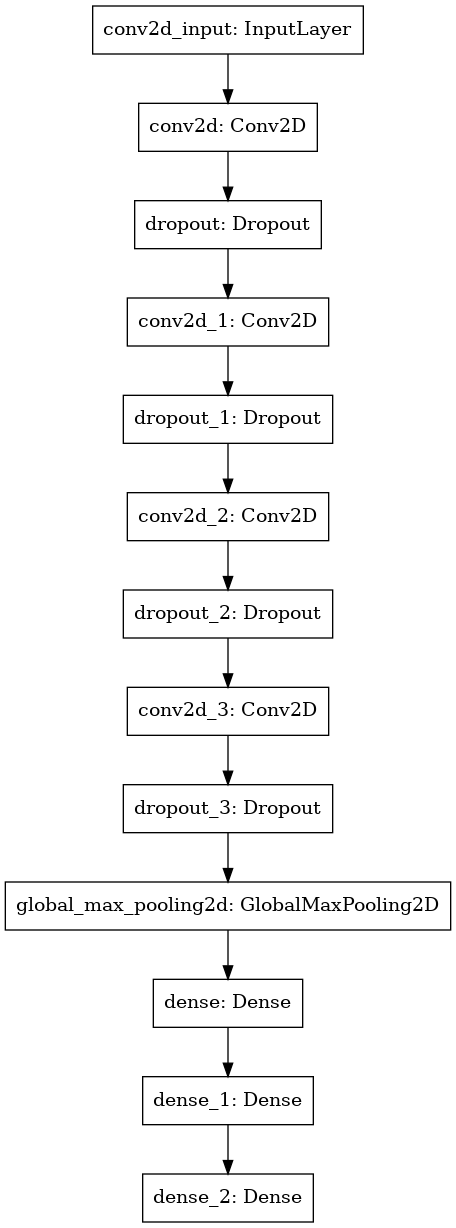

In [5]:
from keras.utils import plot_model
tf.keras.utils.plot_model(wave, to_file='model.png')

In [6]:
wave.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
            )

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = wave.fit(train_x, train_y,
                    epochs=1000,
                    verbose=1,
                    batch_size=128,
                    callbacks=[callback],
                    validation_data = (val_x,val_y)
                  )

Train on 2546 samples, validate on 2455 samples
Epoch 1/1000
2546/2546 [==============================] - 3s 990us/sample - loss: 1.3250 - accuracy: 0.2553 - val_loss: 1.3209 - val_accuracy: 0.4611
Epoch 2/1000
2546/2546 [==============================] - 0s 63us/sample - loss: 1.1363 - accuracy: 0.5436 - val_loss: 1.1833 - val_accuracy: 0.5291
Epoch 3/1000
2546/2546 [==============================] - 0s 54us/sample - loss: 0.9030 - accuracy: 0.6587 - val_loss: 0.8841 - val_accuracy: 0.6978
Epoch 4/1000
2546/2546 [==============================] - 0s 57us/sample - loss: 0.7550 - accuracy: 0.6897 - val_loss: 0.8524 - val_accuracy: 0.6187
Epoch 5/1000
2546/2546 [==============================] - 0s 59us/sample - loss: 0.6743 - accuracy: 0.7227 - val_loss: 0.7842 - val_accuracy: 0.6876
Epoch 6/1000
2546/2546 [==============================] - 0s 60us/sample - loss: 0.6833 - accuracy: 0.7152 - val_loss: 0.7965 - val_accuracy: 0.7059
Epoch 7/1000
2546/2546 [==============================] -

In [8]:
loss, acc = wave.evaluate(test_x,  test_y, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1552/1 - 0s - loss: 0.5811 - accuracy: 0.9014
Restored model, accuracy: 90.14%


In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

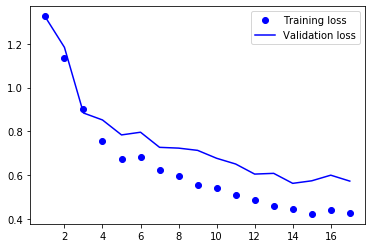

In [10]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.legend()
plt.show()

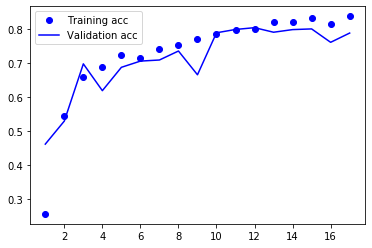

In [11]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend()
plt.show()

In [12]:
def print_cmx(y_true, y_pred, label, title, class_num):
    labels = label
    cmx_data = confusion_matrix(y_true, y_pred)
    
    cmx_data = cmx_data.astype('float') / cmx_data.sum(axis=1)[:, np.newaxis]
    
    cmx_data = cmx_data.round(2)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    plt.figure(figsize = (20,20))
    sn.heatmap(df_cmx, annot=True, fmt='g', square = True, cmap='Reds', vmin=0.0, vmax=1.0)
    sn.set_context('poster')
    
    plt.ylim(class_num, 0)
    plt.ylabel('True Label', fontsize=20)
    plt.xlabel('Prediction Label', fontsize=20)
    plt.title(title, fontsize=30)
    
    plt.show()

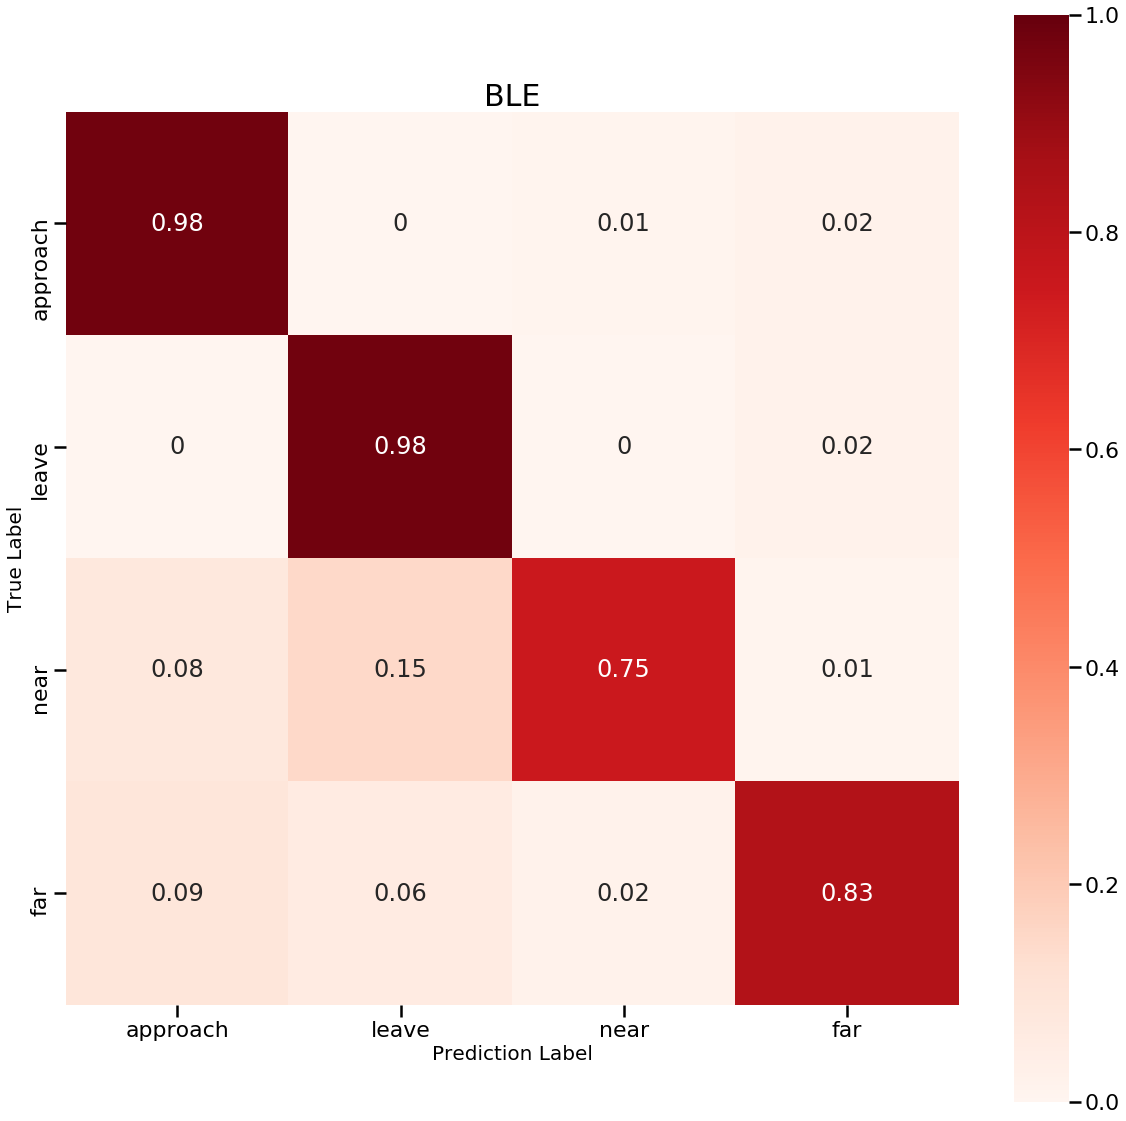

In [15]:
predict_classes = wave.predict_classes(test_x)
true_classes = test_y
title = 'BLE'
class_num = 4
print_cmx(true_classes, predict_classes, ['approach', 'leave', 'near', 'far'], title, class_num)

In [14]:
from sklearn.metrics import precision_recall_fscore_support

x=precision_recall_fscore_support(true_classes,predict_classes)

data = {"適合率": list(x[0]),
        "再現率":list(x[1]),
        "F値":list(x[2]),
       "データ数":list(x[3])}
df = pd.DataFrame(data)
df.index=["approach","leave","near","far"]
df

,適合率,再現率,F値,データ数
approach,0.881857,0.976636,0.926829,428
leave,0.867424,0.984946,0.922457,465
near,0.969231,0.754491,0.848485,334
far,0.934483,0.833846,0.881301,325
